In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, acos, pi
from mpl_toolkits.mplot3d import Axes3D
import Thermal_1D as t_1d

# 1D Heat diffusion considering flux conservation

In [2]:
    
if __name__ == '__main__':
    
    """
    Parameter:
    
    """
    
    Period = 88775.244*670  # [seconds]
    NSTEPS = 50000
    Fgeo = 0.  # [W/m^2]
    Ta=30.; Tm=190.

    STEPSPERSOL = 120
    dt = Period/STEPSPERSOL
    nz = 70; zmax = 2.5; zfac=1.02
    thIn = 120.  # thermal inertia

    rhocv = np.full(nz+1, 1200.*800.)   # (density) * (heat capacity)
    delta = thIn/rhocv[1]*np.sqrt(Period/pi)
    print('Skin depth= ',delta)
    print('zmax=',zmax)
    print('Time step=',dt)
    print('Thermal inertia=',thIn,' Period=',Period)

    fout = open('Tprofile','w') # temperature profile

    T = np.zeros(nz+1)
    ti = np.full(nz+1, thIn)

    z = t_1d.setgrid(nz,zmax,zfac)
    np.savetxt('z', z[1:], fmt='%g', newline=" ")
      
    time = 0.
    Fsurf = 0.

    Tsurf = Tm + Ta*sin(2*pi*time/Period)

    for n in range(0,NSTEPS+1):
        time = (n+1)*dt     #   time at n+1;
        Tsurfp1 = Tm + Ta*sin(2*pi*time/Period) 
        t_1d.Crank1D_T(nz,z,dt,T,Tsurf,Tsurfp1,ti,rhocv,Fgeo,Fsurf)
        Tsurf = Tsurfp1

          # write 12 profiles from the last sol
        if n > NSTEPS-STEPSPERSOL:
            if n%10==9: # synched with test_Tprofile.m
                #print(time/Period, Tsurf)
                np.savetxt(fout,np.column_stack(T[:]),fmt=' %7.2f'*(nz+1) )

      # end of time loop

    fout.close()    



Skin depth=  0.5438991941167934
zmax= 2.5
Time step= 495661.77900000004
Thermal inertia= 120.0  Period= 59479413.480000004


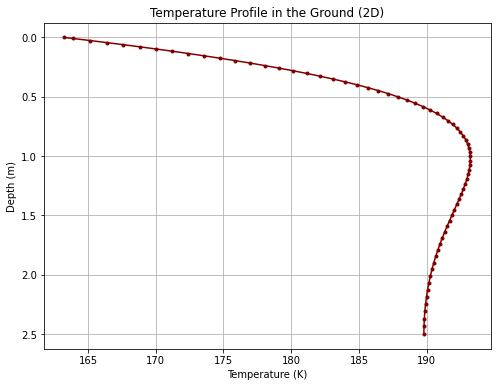

In [3]:
# Plotting temperature profile
t_1d.plot_temperature_profile_2d(z, T)

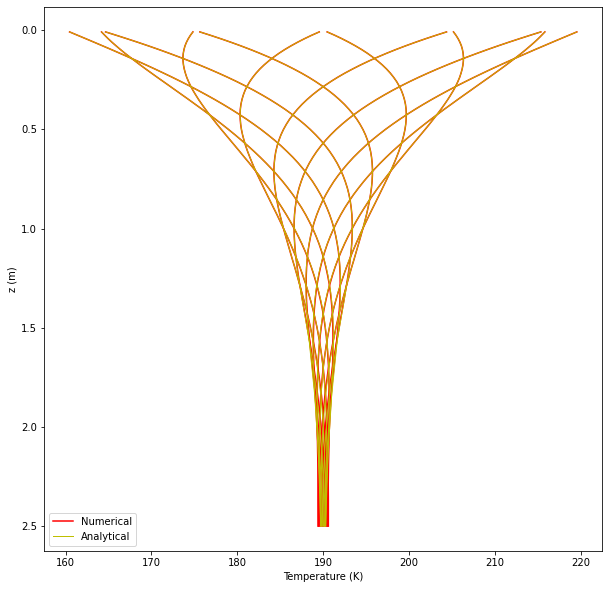

<Figure size 432x288 with 0 Axes>

In [4]:
wpth='./'

a = np.loadtxt(wpth + 'Tprofile')
T = a[:,1:]
z = np.loadtxt(wpth + 'z')


# plot profile
plt.figure(figsize=(10, 10))
plt.plot(T[0,:],z,'r-',label='Numerical')
for i in range(1,12):
    plt.plot(T[i,:],z,'r-')
        
plt.xlabel('Temperature (K)')
plt.ylabel('z (m)')
plt.gca().invert_yaxis()


# compare with analytical solution for sinusoidal surface temperature oscillation and semi-infinite domain
Ta=30.; Tm=190.; P=670.*88775.244
rhoc = 1200*800; thIn=120
delta = thIn/rhoc * np.sqrt(P/np.pi)   # skin depth
w = 2*np.pi/P
dt = P/12
TT = np.zeros(len(z))

for i in range(0,12):
    t = i*dt
    TT = Tm + Ta * np.exp(-z/delta) * np.sin(z/delta-w*t)
    if i==0:
        plt.plot(TT,z,'y-',linewidth=1,label='Analytical')
    else:
        plt.plot(TT,z,'y-',linewidth=1)
        


plt.legend()

plt.show()
plt.savefig('Tprofile_crankT.jpg')

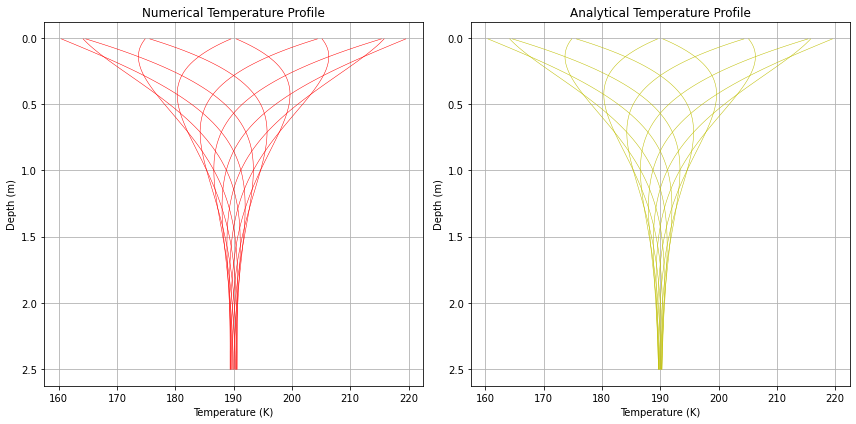

<Figure size 432x288 with 0 Axes>

In [5]:
# Load numerical temperature profiles and depth information

a = np.loadtxt('Tprofile')
T_numerical = a[:, 1:]
z = np.loadtxt('z')

# Plot numerical temperature profiles

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot 1: Numerical solution
for i in range(12):
    plt.plot(T_numerical[i], z, 'r-', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Numerical Temperature Profile')
plt.gca().invert_yaxis()
plt.grid(True)

# Analytical solution parameters

Ta = 30.
Tm = 190.
P = 670. * 88775.244
rhoc = 1200 * 800
thIn = 120
delta = thIn / rhoc * np.sqrt(P / np.pi)  # Skin depth
w = 2 * np.pi / P
dt = P / 12

# Calculate and plot analytical temperature profile

TT_analytical = np.zeros(len(z))
plt.subplot(1, 2, 2)  # Subplot 2: Analytical solution
for i in range(12):
    t = i * dt
    TT_analytical = Tm + Ta * np.exp(-z / delta) * np.sin(z / delta - w * t)
    plt.plot(TT_analytical, z, 'y-', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Analytical Temperature Profile')
plt.gca().invert_yaxis()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('Tprofile_crankT_sep.png',format='png')

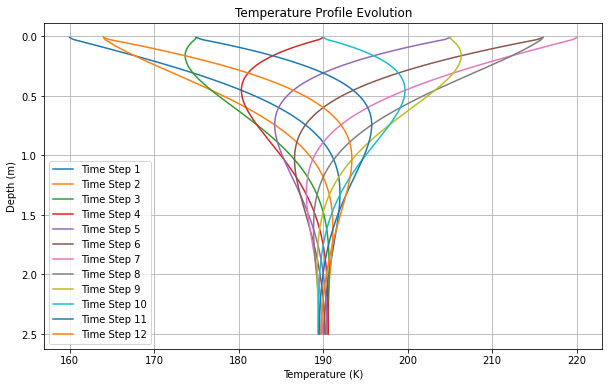

In [6]:
# Load temperature profile data

profile_data = np.loadtxt('Tprofile')
z = np.loadtxt('z')
time_profile = np.arange(len(profile_data))  # Assuming each row corresponds to a time step

# Plot temperature profiles

plt.figure(figsize=(10, 6))
for i in range(12):
    plt.plot(profile_data[i, :-1], z, label=f'Time Step {i+1}')  # Adjusted to match dimensions
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Temperature Profile Evolution')
plt.legend()
plt.gca().invert_yaxis()  # Reverse the y-axis
plt.grid(True)
plt.show()


# Considering Emissions from Thermal radiation

In [7]:
if __name__ == '__main__':
   
    sigSB = 5.6704e-8
    Period = 88775.244*670 # [seconds]
    NSTEPS = 50000
    emiss = 1.
    Fgeo = 0.2  # [W/m^2]

    STEPSPERSOL = 120
    dt = Period / STEPSPERSOL
    thIn = 120.  # thermal inertia
    albedo = 0.2
    latitude = 5.  # [degree]

    nz = 60; zmax = 2.5; zfac = 1.05

    # rhoc = thIn * np.sqrt(Period/pi)  # skin depth = 1
    rhocv = np.full(nz+1, 1200.*800. )  # (density) * (heat capacity)
    delta = thIn/rhocv[1] * np.sqrt(Period/np.pi)
    print('Skin depth= ',delta)
    ti = np.full(nz+1, thIn)

    #T = np.zeros(nz+1)
    #Tmean = np.zeros(nz+1)
    
    Rau = 1.52
    Decl = 0.
  
    print('Time step=',dt)
    print('zmax=',zmax)
    print('Thermal inertia=',thIn,' Period=',Period)
    print('Heat Flux at bottom boundary=',-Fgeo)
    
    # Initialize
    fout1 = open('Tsurface',"w")  # surface temperature
    fout2 = open('Tprofile',"w")  # temperature profile

    T = np.full( nz+1, 210. )
    Tmean = np.zeros_like( T )
    z = t_1d.setgrid(nz,zmax,zfac)
    np.savetxt('z', z[1:], fmt='%g', newline=" ")
    
    latitude = np.deg2rad(latitude)

    time = 0.
    #fout1.write('%12.6f %9.3f %9.3f\n' % (0.,T[0],T[nz]) )
    #np.savetxt(fout2, np.column_stack(T[:]), fmt=" %7.2f"*(nz+1))
    
    Fmean = 0.
    HA = 0.
    Qn = (1-albedo) * t_1d.flux_noatm(Rau,Decl,latitude,HA,0.,0.)
    Fsurf = 0.

    for n in range (0,NSTEPS+1):
        
        time = (n+1)*dt   #   time at n+1; 
        HA = 2 * np.pi * (time/Period % 1.) #  hour angle
        Qnp1 = (1-albedo) * t_1d.flux_noatm(Rau,Decl,latitude,HA,0.,0.)
        t_1d.conduction1D_Q(nz,z,dt,Qn,Qnp1,T,ti,rhocv,emiss,Fgeo,Fsurf)
        Qn = Qnp1

        if n%3 == 0:
            fout1.write('%12.6f %9.3f %9.3f\n' % (time/Period,T[0],T[nz]) )

        if (n > NSTEPS-STEPSPERSOL):
            Fmean += Fmean
            Tmean = Tmean[:] + T[:]            
            if n%10 == 0:
                np.savetxt(fout2,np.column_stack(T[:]),fmt=" %7.2f"*(nz+1))
                
    # end of time loop
    
    Fmean = Fmean / STEPSPERSOL
    Tmean[:] = Tmean[:] / STEPSPERSOL

    fout1.close()
    fout2.close()

Skin depth=  0.5438991941167934
Time step= 495661.77900000004
zmax= 2.5
Thermal inertia= 120.0  Period= 59479413.480000004
Heat Flux at bottom boundary= -0.2


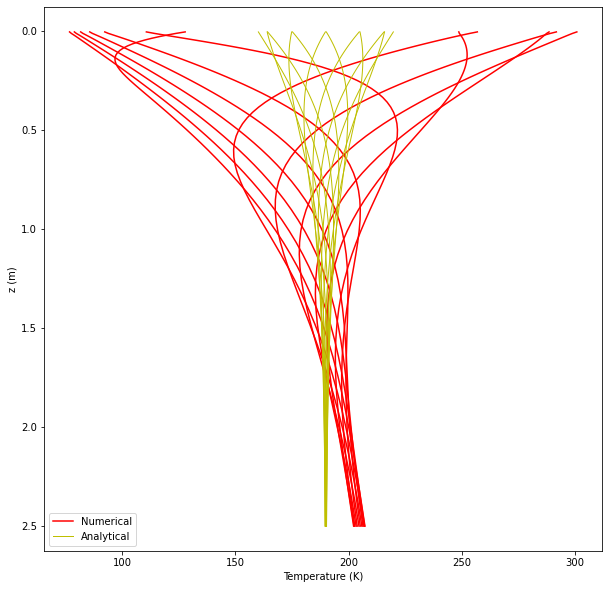

<Figure size 432x288 with 0 Axes>

In [8]:
wpth='./'

a = np.loadtxt(wpth + 'Tprofile')
T = a[:,1:]
z = np.loadtxt(wpth + 'z')


# plot profile
plt.figure(figsize=(10, 10))
plt.plot(T[0,:],z,'r-',label='Numerical')
for i in range(1,12):
    plt.plot(T[i,:],z,'r-')
        
plt.xlabel('Temperature (K)')
plt.ylabel('z (m)')
plt.gca().invert_yaxis()


# compare with analytical solution for sinusoidal surface temperature oscillation and semi-infinite domain

Ta=30.; Tm=190.; P=670.*88775.244
rhoc = 1200*800; thIn=120
delta = thIn/rhoc * np.sqrt(P/np.pi)   # skin depth
w = 2*np.pi/P
dt = P/12
TT = np.zeros(len(z))

for i in range(0,12):
    t = i*dt
    TT = Tm + Ta * np.exp(-z/delta) * np.sin(z/delta-w*t)
    if i==0:
        plt.plot(TT,z,'y-',linewidth=1,label='Analytical')
    else:
        plt.plot(TT,z,'y-',linewidth=1)
        


plt.legend()

plt.show()
plt.savefig('Tprofile_crankQ.png',format='png')

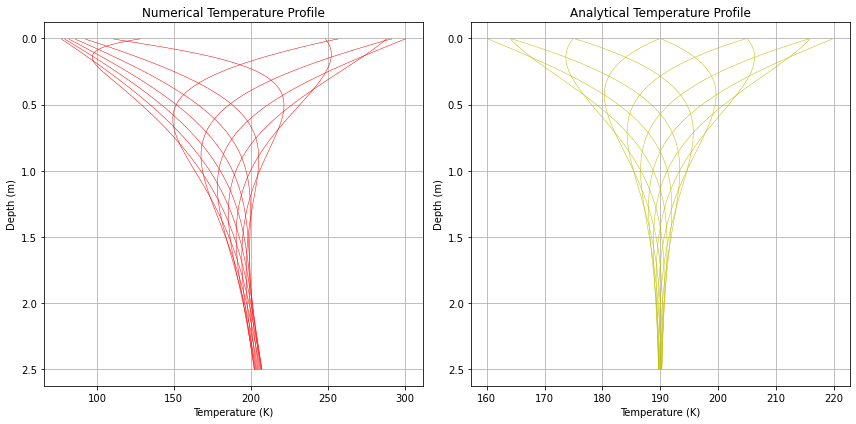

<Figure size 432x288 with 0 Axes>

In [9]:
# Load numerical temperature profiles and depth information

a = np.loadtxt('Tprofile')
T_numerical = a[:, 1:]
z = np.loadtxt('z')

# Plot numerical temperature profiles

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot 1: Numerical solution
for i in range(12):
    plt.plot(T_numerical[i], z, 'r-', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Numerical Temperature Profile')
plt.gca().invert_yaxis()
plt.grid(True)

# Analytical solution parameters

Ta = 30.
Tm = 190.
P = 670. * 88775.244
rhoc = 1200 * 800
thIn = 120
delta = thIn / rhoc * np.sqrt(P / np.pi)  # Skin depth
w = 2 * np.pi / P
dt = P / 12

# Calculate and plot analytical temperature profile

TT_analytical = np.zeros(len(z))
plt.subplot(1, 2, 2)  # Subplot 2: Analytical solution
for i in range(12):
    t = i * dt
    TT_analytical = Tm + Ta * np.exp(-z / delta) * np.sin(z / delta - w * t)
    plt.plot(TT_analytical, z, 'y-', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Analytical Temperature Profile')
plt.gca().invert_yaxis()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('Tprofile_crankQ_sep.png',format='png')

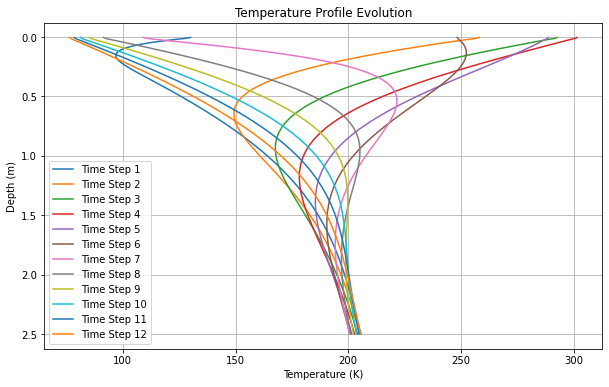

In [10]:
# Load surface temperature data

surface_data = np.loadtxt('Tsurface')
time_surface = surface_data[:, 0]  # Time
surface_temp = surface_data[:, 1]  # Surface temperature

# Load temperature profile data

profile_data = np.loadtxt('Tprofile')
z = np.loadtxt('z')
time_profile = np.arange(len(profile_data))  # Assuming each row corresponds to a time step


# Plot temperature profiles
plt.figure(figsize=(10, 6))
for i in range(12):
    plt.plot(profile_data[i, :-1], z, label=f'Time Step {i+1}')  # Adjusted to match dimensions
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Temperature Profile Evolution')
plt.legend()
plt.gca().invert_yaxis()  # Reverse the y-axis
plt.grid(True)
plt.show()
